# Compute PC1's for each model and save to a file

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from eofs.xarray import Eof
from scipy import signal
import pandas as pd
import xarray as xr
import intake
import pprint 
import util 

if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [2]:
# pick only models with at least 496 yrs in piControl
minyrs_control = 496;
# models with fewer years often missed future scenarios, so they are not so interesting for us

# load table:
data_table = pd.read_table('available_data.txt',index_col=0)
models_used = data_table['piControl (yrs)'][data_table['piControl (yrs)'] >= minyrs_control].index
print(models_used)

Index(['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'MIROC-ES2L',
       'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'GISS-E2-1-H',
       'CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'SAM0-UNICON'],
      dtype='object')


In [3]:
model = models_used[0]
model

'BCC-CSM2-MR'

In [4]:
# what experiments does this model have that we want to study?
exp_list = [exp[:-11] for exp in data_table.loc[model][:6].index if float(data_table.loc[model][:6][exp]) > 0]
print(exp_list)

    

['piControl', 'historical', 'ssp245', 'ssp585']


In [5]:
exp_keys = {}; datasets = {}

for exp in exp_list:
    print(exp)
    cat = col.search(experiment_id = exp, source_id = model, variable_id='ts', table_id='Amon')
        
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    for key in dset_dict.keys():
        exp_keys[exp] = key
        datasets[key] = dset_dict[key]

exp_keys

piControl

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
historical

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp245

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned

{'piControl': 'CMIP.BCC.BCC-CSM2-MR.piControl.Amon.gn',
 'historical': 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'ssp245': 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp245.Amon.gn',
 'ssp585': 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn'}

In [6]:
def area_weights(lat_bnds, lon_bnds): 
    # computes exact area weigths assuming earth is a perfect sphere
    lowerlats = np.radians(lat_bnds[:,0]); upperlats = np.radians(lat_bnds[:,1])
    difflon = np.radians(np.diff(lon_bnds[0,:])) # if the differences in longitudes are all the same
    areaweights = difflon*(np.sin(upperlats) - np.sin(lowerlats));
    areaweights /= areaweights.mean()
    return areaweights # list of weights, of same dimension as latitude

def numerical_midmonths(xdata):
    # converts xarray monthly time data to numpy array with numerical values
    # for use in functions that cannot use xarray times as input
    midmonths = [int(str(xdata[i])[:4]) + 0.5/12 + int(str(xdata[i])[5:7])/12 for i in range(xdata.shape[0])]
    return np.array(midmonths)

def xpolyfit3D(xarray, axis=0, order=1): 
    # a function that can do regression over a 3D array over dimension specified by axis
    # default: linear regression
    # can currently be used only for monthly data
    
    xdata = xarray.time.values; ydata = xarray.values
    dims = list(np.shape(ydata)); axisdim = dims[axis]; dims.pop(axis)
    
    # Reshape to an array with as many rows as time dim. and as many columns as there are grid boxes
    y2 = ydata.reshape(axisdim, np.prod(dims))
    #regression_results = xr.apply_ufunc(np.polyfit, numerical_midmonths(xdata), y2, order, dask = 'allowed')
    regression_results = np.polyfit(numerical_midmonths(xdata), y2, order)
    # Reshape to original shape and return results
    reg_par = regression_results.reshape(order+1, dims[0], dims[1])
    return reg_par

def xpolyval3D(regression_parameters, xarray_times):
    # uses the parameters found in xpolyfit3D to compute a trend
    # xarray_times should be on format xarray.time.values;
    time_dim = len(xarray_times);
    par_dims = list(np.shape(regression_parameters)); npars = par_dims[0]; par_dims.pop(0)
    
    trends = np.full((time_dim ,par_dims[0],par_dims[1]), np.nan)
    times = numerical_midmonths(xarray_times)
    for i in range(par_dims[0]):
        for j in range(par_dims[1]):
            trends[:,i,j] = np.polyval(regression_parameters[:,i,j], times)
    return trends
    
    

In [7]:
latregion = slice(-30,30); lonregion = slice(100, 360-70) #100E to 70W

pc1s = {}

#for exp in [exp_list[0]]: # should always start with piControl
for exp in exp_list[0:2]:
    key = exp_keys[exp]
    exp_datasets = datasets[key]
    members_sorted = exp_datasets.member_id.sortby(exp_datasets.member_id)
    for member in members_sorted.values:
        print(exp, member)
        
        ds = exp_datasets.sel(member_id = member)
        branchyear = ds.branch_time_in_parent
        exp_endyear = int(str(ds.time.values[-1])[:4])
        
        regional_data = ds.ts.sel(lat = latregion, lon = lonregion)
        
        weights = area_weights(ds['lat_bnds'], ds['lon_bnds']).sel(lat=latregion)
        
        # define anomalies relative to piControl climatology
        # subtract also linear trend computed from piControl, in case it has a drift.
        if exp == 'piControl':
            control_clim = regional_data.groupby('time.month').mean(dim='time')
            anomalies = regional_data.groupby('time.month') - control_clim
            
            control_trend_pars = xpolyfit3D(anomalies)
            control_trend = xpolyval3D(control_trend_pars, anomalies.time.values)
            control_years = np.array([int(str(ds.time.values[i])[:4]) for i in range(len(ds.time))])
            year_offset = 0
        else:
            # control_clim should be computed earlier in loop
            anomalies = regional_data.groupby('time.month') - control_clim
            exp_startyear = int(str(ds.time.values[0])[:4])
            year_offset = (exp_startyear) - control_years[0] + (branchyear - control_years[0])  # will be >= 0
            
        # find corresponding time indexes in control run:
        ind = ((control_years >= branchyear) & (control_years <= exp_endyear + year_offset))
        # subtract trend (which may be tiny in case of no drift)
        if np.sum(ind) > len(ds.time):
            detrended_anomalies = anomalies - control_trend[ind,:,:]
        else: 
            # then exp starts in the end of piControl, and we can assume it has stabilized,
            # and trend = 0
            detrended_anomalies = anomalies
        
        if exp != 'piControl':
            # subtract also trend due to the forcing:
            # start simple, by subtracting linear trend: (consider improving trend estimate later)
            detrended_anomalies = xr.apply_ufunc(detrend, detrended_anomalies, kwargs={'axis': 0}, dask = 'allowed')
        detrended_anomalies_t = detrended_anomalies.transpose('time', 'lon', 'lat')
        
        # Do EOF analysis
        solver = Eof(detrended_anomalies_t, weights=np.sqrt(weights)) # takes 1.5 h for 600yr control run
        eof1 = solver.eofsAsCorrelation(neofs=1)
        pc1 = solver.pcs(npcs=1, pcscaling=0)
        pc1s[exp][member] = pc1


piControl r1i1p1f1


KeyError: 'piControl'

In [16]:
solver

In [32]:
#eof1.to_netcdf('eof1_piControl_BCC-CSM2-MR.nc')
#pc1.to_netcdf('pc1_piControl_BCC-CSM2-MR.nc')

In [55]:
np.sqrt(weights).values

array([1.16614684, 1.17253226, 1.17865968, 1.18453076, 1.19014707,
       1.19551006, 1.20062108, 1.20548139, 1.21009217, 1.21445449,
       1.21856937, 1.22243773, 1.22606042, 1.22943825, 1.23257194,
       1.23546214, 1.23810945, 1.24051443, 1.24267756, 1.24459927,
       1.24627995, 1.24771992, 1.24891947, 1.24987884, 1.2505982 ,
       1.2510777 , 1.25131742, 1.25131742, 1.2510777 , 1.2505982 ,
       1.24987884, 1.24891947, 1.24771992, 1.24627995, 1.24459927,
       1.24267756, 1.24051443, 1.23810945, 1.23546214, 1.23257194,
       1.22943825, 1.22606042, 1.22243773, 1.21856937, 1.21445449,
       1.21009217, 1.20548139, 1.20062108, 1.19551006, 1.19014707,
       1.18453076, 1.17865968, 1.17253226, 1.16614684])

In [56]:
np.sum(np.sqrt(weights).values)

65.98881570740413

In [27]:
eigenvalues = solver.eigenvalues()
eigenvalues

<xarray.DataArray 'eigenvalues' (mode: 7200)>
array([1.6487118e+03, 8.0239087e+02, 3.5576147e+02, ..., 7.2519316e-07,
       6.9796044e-07, 9.5013725e-14], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 ... 7193 7194 7195 7196 7197 7198 7199
Attributes:
    long_name:  eigenvalues

In [28]:
solver.eigenvalues(neigs=1)

<xarray.DataArray 'eigenvalues' (mode: 1)>
array([1648.7118], dtype=float32)
Coordinates:
  * mode     (mode) int64 0
Attributes:
    long_name:  eigenvalues

In [29]:
variance_fractions = solver.varianceFraction()

In [30]:
variance_fractions

<xarray.DataArray 'variance_fractions' (mode: 7200)>
array([2.28092611e-01, 1.11007534e-01, 4.92181629e-02, ...,
       1.00327545e-10, 9.65600100e-11, 1.31447652e-17], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 ... 7193 7194 7195 7196 7197 7198 7199
Attributes:
    long_name:  variance_fractions

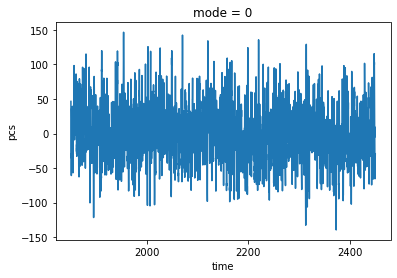

In [8]:
pc1.plot()

In [57]:
w_sum = (np.sum(np.sqrt(weights).values))

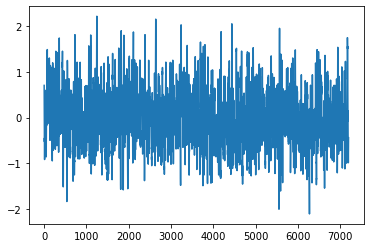

In [58]:
plt.plot(pc1/w_sum)

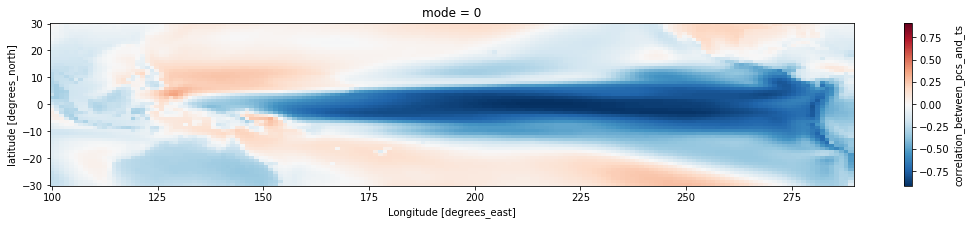

In [11]:
eof1.transpose().plot(aspect = 6, size = 3)

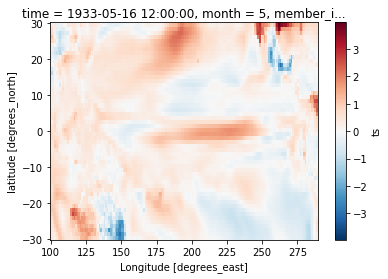

In [53]:
anomalies.isel(time=1000).plot()